In [128]:
# @Author Euclidi Filippo - matr. 294517

# Importing all needed libraries.

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Features Selection methods imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
  
# Data preprocessing methods imports
from sklearn import preprocessing 

# Train test split imports
from sklearn.model_selection import train_test_split

# Score evaluating methods imports
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Classifications Models imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier  #To use this, use compatible kernel 
                                    # (conda tensorflow on mac m1 is not compatible)

# Model Selection and Cross Validation imports
from sklearn.model_selection import KFold

# Neural Network imports
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

In [129]:
# I'm now going to create a function to calculate the accuracy of the predicted values

def score(y_test, y_pred, specification):
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average=specification)
    c_mat = confusion_matrix(y_test, y_pred)
    return acc, f1, c_mat

In [130]:
def kFoldCrossValidation(model, X, y):
    k = 10
    kf = KFold(n_splits=k, random_state=None)
    acc_score = []
    f1_score = []
    prec_matrix = []
        
    for train_index , test_index in kf.split(X):
        X_train , X_test = X[train_index,:],X[test_index,:]
        y_train , y_test = y[train_index] , y[test_index]
        
        model.fit(X_train,y_train)
        pred_values = model.predict(X_test)
        acc, f1, prec_m = score(y_test, pred_values, 'weighted')
        acc_score.append(acc)
        f1_score.append(f1)
        prec_matrix.append(prec_m)
            
    avg_acc_score = sum(acc_score)/k
    avg_f1_score = sum(f1_score)/k
    avg_prec_mat = sum(prec_matrix)/k
    print("Accuracy score: "+str(avg_acc_score) + " \nF1 Score:" + str(avg_f1_score) 
          + " \nAverage Precision Matrix:\n" + str(avg_prec_mat))

In [131]:
# Setting train and test set by importing the datasets
df_train = pd.read_csv("./archive/train.csv")
df_test = pd.read_csv("./archive/test.csv")

In [132]:
# First of all lets create our dataset X (multidimensional array) by removing the price_range
# column which will be our target value to check how good is a classifier

X = df_train.iloc[:, 0:-1]
X = df_train.drop(columns = ['price_range'])

In [133]:
# Now we will create our y array containing all the values which we expect from our classifier

y = df_train['price_range'].values

In [134]:
# We are now going to do some feature selection using the chi-square function 

bestfeatures = SelectKBest(score_func=chi2, k=2)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score'] #naming the dataframe columns
print(featureScores)

# Lets create a function to determine the best number of features for all the models
def findBestFeatures(model, X_train, y_train):
    accuracy_list_train = []
    k=np.arange(1,21,1)
    for each in k:
        x_new = SelectKBest(score_func=chi2, k=each).fit_transform(X_train, y_train)
        model.fit(x_new,y_train)
        accuracy_list_train.append(model.score(x_new,y_train))   
    plt.plot(k,accuracy_list_train,color="green",label="train")
    plt.xlabel("k values")
    plt.ylabel("train accuracy")
    plt.legend()
    plt.show()

            Specs          Score
0   battery_power   14129.866576
1            blue       0.723232
2     clock_speed       0.648366
3        dual_sim       0.631011
4              fc      10.135166
5          four_g       1.521572
6      int_memory      89.839124
7           m_dep       0.745820
8       mobile_wt      95.972863
9         n_cores       9.097556
10             pc       9.186054
11      px_height   17363.569536
12       px_width    9810.586750
13            ram  931267.519053
14           sc_h       9.614878
15           sc_w      16.480319
16      talk_time      13.236400
17        three_g       0.327643
18   touch_screen       1.928429
19           wifi       0.422091


In [135]:
# We need to do some preprocessing 
# Lets apply a Standard Scaler which standardizes the features by removing the mean
# and scaling to unit variance 
# .fit(X) computes the mean and std (standard deviation) of the X array
# .transform(X) uses the computed mean and std and performs on X the standardization

X_NoPrep = X.to_numpy()

X = preprocessing.StandardScaler().fit(X).transform(X) #Preprocessed for better accuracy
X_norm = preprocessing.MinMaxScaler().fit(X).transform(X) #Normalized for feature selection

# Doing some feature selection is going to give us better results and reduce the time needed 
# for computation
X_new = SelectKBest(chi2, k=5).fit_transform(X_norm, y)

print(X) #Lets visualize it
print(X_norm)

[[-0.90259726 -0.9900495   0.83077942 ... -1.78686097 -1.00601811
   0.98609664]
 [-0.49513857  1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 [-1.5376865   1.0100505  -1.2530642  ...  0.55964063  0.99401789
  -1.01409939]
 ...
 [ 1.53077336 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
  -1.01409939]
 [ 0.62252745 -0.9900495  -0.76274805 ...  0.55964063  0.99401789
   0.98609664]
 [-1.65833069  1.0100505   0.58562134 ...  0.55964063  0.99401789
   0.98609664]]
[[0.22778891 0.         0.68       ... 0.         0.         1.        ]
 [0.34736139 1.         0.         ... 1.         1.         0.        ]
 [0.04141617 1.         0.         ... 1.         1.         0.        ]
 ...
 [0.94188377 0.         0.16       ... 1.         1.         0.        ]
 [0.6753507  0.         0.16       ... 1.         1.         1.        ]
 [0.00601202 1.         0.6        ... 1.         1.         1.        ]]


In [136]:
# Lets split our database in to training and test and do some model comparison on 
# these datasets
 
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.10, stratify=y)
X_trainNoP, X_validationNoP, y_trainNoP, y_validationNop = train_test_split(X_norm, y, test_size = 0.10, stratify=y)

In [137]:
# As first Model we will use a Logistic Regression Classifier

#avg = np.mean(X_train, axis=0)
#std = np.std(X_train,axis=0)
#X_train = (X_train-avg/std)

# I tried adding doing some feature scaling, but the models Accuracy didn't seem to be
# improving in any way while doing so, some also showed worse results


print("Logistic Regression Classifier")
logreg = LogisticRegression()
kFoldCrossValidation(logreg, X, y)

#findBestFeatures(logreg, X_trainNoP, y_trainNoP)
print("")

Logistic Regression Classifier
Accuracy score: 0.9620000000000001 
F1 Score:0.9619377956142546 
Average Precision Matrix:
[[49.   1.   0.   0. ]
 [ 1.5 47.4  1.1  0. ]
 [ 0.   1.6 47.   1.4]
 [ 0.   0.   1.  49. ]]



Decision Tree Classifier
Accuracy score: 0.842 
F1 Score:0.8422014702255002 
Average Precision Matrix:
[[44.9  5.1  0.   0. ]
 [ 4.9 39.7  5.4  0. ]
 [ 0.   5.1 40.4  4.5]
 [ 0.   0.   6.6 43.4]]


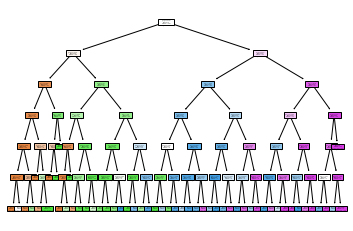

In [138]:
# As second model we will use a Decision Tree Classifier

print("Decision Tree Classifier")
clf=DecisionTreeClassifier(max_depth=6)
kFoldCrossValidation(clf, X, y)
plot_tree(clf, filled=True)
plt.show()
print("")

In [139]:
# Since the decision tree classifier wasn't very successful lets try with 
# a Random Forest Classifier

print("Random Forest Classifier")
rf = RandomForestClassifier(n_estimators=200)
kFoldCrossValidation(rf, X, y)
print("")

Random Forest Classifier
Accuracy score: 0.8855000000000001 
F1 Score:0.8854691202103917 
Average Precision Matrix:
[[47.   3.   0.   0. ]
 [ 3.6 42.3  4.1  0. ]
 [ 0.   5.5 41.2  3.3]
 [ 0.   0.   3.4 46.6]]



In [140]:
# We will now also try with a Support Vector Machine, since the random forest model wasn't 
# a great success by any means

print("Support Vector Machine Classifier")
svm_clf = SVC()
kFoldCrossValidation(svm_clf, X_NoPrep, y)
#findBestFeatures(svm_clf, X_trainNoP, y_trainNoP)
print("")

Support Vector Machine Classifier
Accuracy score: 0.9504999999999999 
F1 Score:0.950297976732335 
Average Precision Matrix:
[[49.1  0.9  0.   0. ]
 [ 1.5 47.7  0.8  0. ]
 [ 0.   2.6 45.   2.4]
 [ 0.   0.   1.7 48.3]]



In [141]:
# Lets also try with some other classifiers like the Bagging Classifier, the AdaBoost 
# (adaptive boosting), the Gradient Boosting and the XGBoost (extreme gradient boosting)
# 200 estimators will be used for all of them, to keep it even and not make computational 
# time too long

# First lets use the bagging classifier

print("Bagging Classifier")
bc = BaggingClassifier(n_estimators = 200)
kFoldCrossValidation(bc, X, y)
#findBestFeatures(bc, X_trainNoP, y_trainNoP)
print("")

Bagging Classifier



In [142]:
#The bagging classifier seems to give an ok result although the computational time it's very long

# Then we will use the Adaptive Boosting

print("AdaBoost")

ab = AdaBoostClassifier(n_estimators = 200)
X_AdaBoost = SelectKBest(chi2, k=3).fit_transform(X_norm,y)

#X_AdaBoost = X_AdaBoost[:, [0,1,2,5,6]]
#print(X_AdaBoost)

kFoldCrossValidation(ab, X_AdaBoost, y)
#findBestFeatures(ab, X_norm, y)
print("")


AdaBoost
Accuracy score: 0.8215 
F1 Score:0.8212556257530677 
Average Precision Matrix:
[[42.8  7.2  0.   0. ]
 [ 4.  38.6  7.4  0. ]
 [ 0.   5.3 38.3  6.4]
 [ 0.   0.   5.4 44.6]]



In [143]:
# Then the Gradient Boosting

print("Gradient Boosting")
gb = GradientBoostingClassifier(n_estimators = 200)
kFoldCrossValidation(gb, X, y)
#findBestFeatures(gb, X_trainNoP, y_trainNoP)
print("")

Gradient Boosting
Accuracy score: 0.913 
F1 Score:0.9130838970524007 
Average Precision Matrix:
[[47.7  2.3  0.   0. ]
 [ 2.3 45.3  2.4  0. ]
 [ 0.   3.7 43.6  2.7]
 [ 0.   0.   4.  46. ]]



In [144]:
# And finally the Extreme Gradient Boosting

#Uncomment only if using xgboost compatible kernel
#print("Extreme Gradient Boosting:")
# Using label encoder false, to remove a warning, and eval_metric='logloss' for improved 
# results eval_metric='mlogloss' also shows good results
#xgb = XGBClassifier(n_estimators = 200,  use_label_encoder=False, eval_metric='logloss')
#kFoldCrossValidation(xgb, X_NoPrep, y)
#print("")

# All of these models could be implemented in to a for cycle, but i wanted to show all the 
# actual full code behind it even if very repetitive for explainability and tuning purposes.

Epoch 1/100
16/23 [===================>..........] - ETA: 0s - loss: 1.3738 - accuracy: 0.3770

2022-04-11 22:39:44.356290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 12ms/step - loss: 1.3700 - accuracy: 0.3799 - val_loss: 1.3499 - val_accuracy: 0.4056
Epoch 2/100
15/23 [==================>...........] - ETA: 0s - loss: 1.3430 - accuracy: 0.4083

2022-04-11 22:39:44.631503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 9ms/step - loss: 1.3369 - accuracy: 0.4139 - val_loss: 1.3199 - val_accuracy: 0.4250
Epoch 3/100
23/23 [==============================] - 0s 8ms/step - loss: 1.3027 - accuracy: 0.5097 - val_loss: 1.2792 - val_accuracy: 0.5278
Epoch 4/100
23/23 [==============================] - 0s 8ms/step - loss: 1.2562 - accuracy: 0.5618 - val_loss: 1.2203 - val_accuracy: 0.5500
Epoch 5/100
23/23 [==============================] - 0s 8ms/step - loss: 1.1911 - accuracy: 0.5833 - val_loss: 1.1450 - val_accuracy: 0.5528
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 1.1130 - accuracy: 0.6049 - val_loss: 1.0645 - val_accuracy: 0.5694
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 1.0361 - accuracy: 0.6146 - val_loss: 0.9856 - val_accuracy: 0.6056
Epoch 8/100
23/23 [==============================] - 0s 8ms/step - loss: 0.9607 - accuracy: 0.6451 - val_loss: 0.9129 - val_accuracy: 0.6472
Epoch 9/100
23/23 [======

2022-04-11 22:40:02.595903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


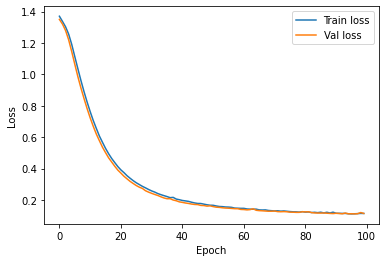

Accuracy score: 0.92 
F1 Score:0.9195631963119477 
Precision Matrix:
[[66  1  0  0]
 [ 4 40  0  0]
 [ 0  3 42  2]
 [ 0  0  6 36]]


In [145]:
# As we can see the best models are the Linear Regression, the Logistic Regression,
# the Gradient Boosting and the Extreme Gradient Boosting.
# Some decent results were also seen in the Random Forest Classifier, the Bagging 
# Classifier and the Support Vector Machine.
# The support vector machine shows great results when there is no preprocessing applied 
# to the X_train dataset 95% accuracy

# Lets see now how a Neural Network can deal with this dataset and its classification

# We need to make y categorical as we are going to use a softmax as final layer 
# for multi-class classification
y = to_categorical(y)

# We are going to use a different training set and test set for the Neural Network since we 
# made y categorical
X_train, X_validation, y_train, y_validation = train_test_split(X_new, y, test_size = 0.10)

# The model that we are going to use is sequential
model = models.Sequential()
#The first layer that you define is the input layer. This layer needs to know the 
# input dimensions of your data.
# Dense = fully connected layer (each neuron is fully connected to all neurons 
# in the previous layer)
model.add(layers.Dense(18, activation='relu',input_dim=5))
# Add one hidden layer (after the first layer, you don't need to specify 
# the size of the input anymore)
model.add(layers.Dense(18, activation='relu'))
# If you don't specify anything, no activation is applied (ie."linear" activation: a(x) = x)
model.add(layers.Dense(4,activation='softmax'))

opt = optimizers.Adam()

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Fit the model to the training data and record events into a History object.
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Model evaluation
test_loss,test_pr = model.evaluate(X_validation,y_validation)
y_pred = model.predict(X_validation)
print(test_pr)

pred = list()

test = list()

for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

for i in range(len(y_validation)):
    test.append(np.argmax(y_validation[i]))


print("Neural Network: ")
# Plotting loss and epochs for training set and validation set
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch,
np.array(history.history['loss']),label='Train loss')
plt.plot(history.epoch,
np.array(history.history['val_loss']),label = 'Val loss')
plt.legend()
plt.show()

acc, f1, prec_m = score(pred, test, 'weighted')
print("Accuracy score: "+str(acc) + " \nF1 Score:" + str(f1) 
          + " \nPrecision Matrix:\n" + str(prec_m))

In [146]:
# In this last run we got a decent result also from the Neural Network, yet this machine
# learning technicque its very time consuming and the results aren't always as good as
# expected. In the last run for example we got an accuracy score of 0.945 while the Logistic 
# Regression got a 0.963 in just 0.3 seconds compared to the wapping 18.5 seconds taken by the 
# Neural Network.